In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools
#import umap

In [2]:
#FUNCIÓN: lee los .csv y los agrupa por ID (cada evacuación) y crea entonces una lista de lista de las matrices
def descargar_matrices_por_id(ruta_carpeta):
    id_dict = {}  # Diccionario para agrupar por ID

    for archivo in os.listdir(ruta_carpeta):
        if archivo.endswith('.csv'):   #coger solo los b0
            partes = archivo.split('_') 
            if len(partes) < 2:
                continue  # Saltar si no tiene el formato esperado

            id_str = partes[1]  # El ID es el segundo bloque: mb0_000101_2.csv

            if id_str not in id_dict:
                id_dict[id_str] = []

            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            df = pd.read_csv(ruta_archivo, skiprows=1, header=None)
            id_dict[id_str].append(df.values)

    # Convertir a lista de listas ordenadas por ID
    ids_ordenados = sorted(id_dict.keys())
    lista_de_listas = [id_dict[k] for k in ids_ordenados]

    return lista_de_listas

### Descargar matrices

In [3]:
#empujando = 0
#sin empujar = 1
ruta_0 = './b0_empujando_100'
ruta_1 = './b0_sin_empujar_100'

lista_0 = descargar_matrices_por_id(ruta_0)
lista_1 = descargar_matrices_por_id(ruta_1)

### Separamos train y test

In [4]:
#separamos manualmente
idx_train_0 = [2,0]
idx_test_0 = [1]

idx_train_1 = [2,0]
idx_test_1 = [1]

In [5]:
#FUNCIÓN: unificamos las listas que nos interesa y convertimos a arrays
def convertir_lista_array(lista,idx):
    
    np.random.seed(42) 
    train =  [lista[i] for i in idx]                  #nos quedamos con los indices que queremos de la lista
    lista_train = list(itertools.chain.from_iterable(train))        #unificamos los arrays en una sola lista
    array_train = np.array(lista_train)          #convertimos a array
    #np.random.shuffle(array_train)   #mezclar los frames

    return array_train

In [6]:
array_train_0 = convertir_lista_array(lista_0,idx_train_0)
array_train_1 = convertir_lista_array(lista_1,idx_train_1)
array_test_0 = convertir_lista_array(lista_0,idx_test_0)
array_test_1 = convertir_lista_array(lista_1,idx_test_1)

print('train:',array_train_0.shape,array_train_1.shape)
print('test:',array_test_0.shape,array_test_1.shape)

train: (2795, 50, 20) (2410, 50, 20)
test: (1440, 50, 20) (1086, 50, 20)


In [7]:
#balancear el conjunto de datos para que ambas clases (0 y 1) tengan el mismo número de muestras tanto en entrenamiento como en test. 
np.random.seed(42)

n_train = len(array_train_1)  #numero de muestras
n_test = len(array_test_1) 

# Elegir el mismo num de matrices con índices aleatorios de la clase mayoritaria
idx_train_0 = np.random.choice(array_train_0.shape[0], size=n_train, replace=False)
idx_test_0 = np.random.choice(array_test_0.shape[0], size=n_test, replace=False)

# Subconjuntos balanceados
datos_train_0 = array_train_0[idx_train_0]
datos_train_1 = array_train_1

datos_test_0 = array_test_0[idx_test_0]
datos_test_1 = array_test_1

print('train:',datos_train_0.shape,datos_train_1.shape)
print('test:',datos_test_0.shape,datos_test_1.shape)

train: (2410, 50, 20) (2410, 50, 20)
test: (1086, 50, 20) (1086, 50, 20)


### Convertimos a vectores

In [8]:
#pasa de matriz a vectores formando una sola matriz donde cada fila es una evacuacion de 4 segundos
matriz_train_0 = datos_train_0.reshape((n_train,-1))            #-1 calcula la dimension automaticamente
matriz_train_1 = datos_train_1.reshape((n_train,-1))
    
matriz_test_0 = datos_test_0.reshape((n_test,-1))            
matriz_test_1 = datos_test_1.reshape((n_test,-1))

In [9]:
#creamos los labels
labels_train_0 = np.array([0]*n_train)
labels_train_1 = np.array([1]*n_train)

labels_test_0 = np.array([0]*n_test)
labels_test_1 = np.array([1]*n_test)

(labels_train_0.shape, labels_train_1.shape)

((2410,), (2410,))

In [10]:
X_train = np.concatenate((matriz_train_0, matriz_train_1), axis=0)  
y_train = np.concatenate((labels_train_0, labels_train_1), axis=0) 

X_test = np.concatenate((matriz_test_0, matriz_test_1), axis=0)  
y_test = np.concatenate((labels_test_0, labels_test_1), axis=0) 

print('train:',X_train.shape, y_train.shape)
print('test:',X_test.shape, y_test.shape)

train: (4820, 1000) (4820,)
test: (2172, 1000) (2172,)


In [11]:
from sklearn.utils import shuffle

# Mezclar entrenamiento
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Mezclar test
X_test, y_test = shuffle(X_test, y_test, random_state=42)

### Normalizamos

In [12]:
#normalizamos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)   # Ajusta y transforma solo sobre train
X_test_norm = scaler.transform(X_test)         # Transforma test con el mismo scaler

# MODELOS: No supervisados

## PCA

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train_norm)

X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)


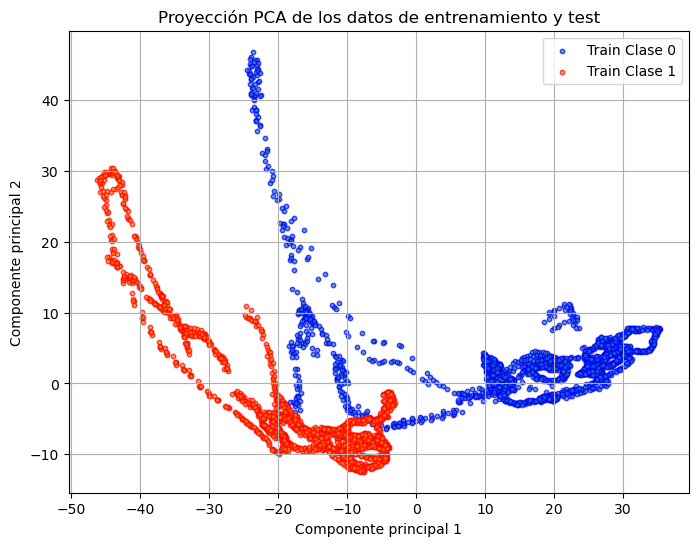

In [14]:
plt.figure(figsize=(8,6))

# Train clase 0
plt.scatter(
    X_train_pca[y_train == 0, 0], 
    X_train_pca[y_train == 0, 1], 
    label='Train Clase 0', alpha=0.7, edgecolors='b', s=10
)

# Train clase 1
plt.scatter(
    X_train_pca[y_train == 1, 0], 
    X_train_pca[y_train == 1, 1], 
    label='Train Clase 1', alpha=0.7, edgecolors='r', s=10
)

plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Proyección PCA de los datos de entrenamiento y test')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
#print(pca.components_)
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

Varianza explicada por cada componente:
[0.43609373 0.0769068 ]


## UMAP

## K-means

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# Elegimos 2 clusters porque tenemos 2 clases
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_norm)

# Predicciones (etiquetas de cluster)
y_pred_cluster = kmeans.predict(X_test_norm)

# Como KMeans asigna etiquetas arbitrarias (0 o 1 sin relación con tus clases reales),
# necesitamos hacer una asignación "inteligente":
def ajustar_etiquetas(pred, true):
    labels = np.zeros_like(pred)
    for i in np.unique(pred):
        mask = pred == i
        labels[mask] = mode(true[mask])[0]
    return labels

y_pred_ajustado = ajustar_etiquetas(y_pred_cluster, y_test)

# Medimos la precisión
accuracy_kmeans = accuracy_score(y_test, y_pred_ajustado)
print(f"Accuracy K-Means: {accuracy_kmeans * 100:.2f}%")


Accuracy K-Means: 87.48%


# MODELOS: Supervisados

## Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model1 = LogisticRegression(random_state=42) 

model1.fit(X_train_norm, y_train)

y_pred = model1.predict(X_test_norm)

accuracy_LR = accuracy_score(y_test, y_pred)

print(f"Accuracy_LR: {accuracy_LR * 100:.2f}%")

Accuracy_LR: 92.45%


In [18]:
#con PCA:

model1 = LogisticRegression(random_state=42)

# Entrenar con datos transformados por PCA
model1.fit(X_train_pca, y_train)

# Predecir con datos transformados por PCA
y_pred = model1.predict(X_test_pca)

accuracy_LR_pca = accuracy_score(y_test, y_pred)

print(f"Accuracy_LR con PCA: {accuracy_LR_pca * 100:.2f}%")


Accuracy_LR con PCA: 84.94%


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators = 30,random_state=42)

model2.fit(X_train_norm, y_train)
y_pred2 = model2.predict(X_test_norm)
accuracy_RF = accuracy_score(y_test, y_pred2)

print(f"Accuracy_RF: {accuracy_RF * 100:.2f}%")

Accuracy_RF: 86.37%


In [20]:
#con PCA

model2 = RandomForestClassifier(n_estimators=30, random_state=42)

# Entrenar con datos PCA
model2.fit(X_train_pca, y_train)

# Predecir con datos PCA
y_pred2 = model2.predict(X_test_pca)

accuracy_RF_pca = accuracy_score(y_test, y_pred2)

print(f"Accuracy_RF con PCA: {accuracy_RF_pca * 100:.2f}%")

Accuracy_RF con PCA: 75.41%


## KNeighbors

In [21]:
from sklearn.neighbors import KNeighborsClassifier
model3 = KNeighborsClassifier(n_neighbors=3)

model3.fit(X_train_norm, y_train)
y_pred3 = model3.predict(X_test_norm)

accuracy_KN = accuracy_score(y_test, y_pred3)
print(f"Accuracy_KN: {accuracy_KN * 100:.2f}%")

Accuracy_KN: 90.75%


In [22]:
#con PCA

model3 = KNeighborsClassifier(n_neighbors=3)

# Entrenar con datos PCA
model3.fit(X_train_pca, y_train)

# Predecir con datos PCA
y_pred3 = model3.predict(X_test_pca)

accuracy_KN_pca = accuracy_score(y_test, y_pred3)
print(f"Accuracy_KN con PCA: {accuracy_KN_pca * 100:.2f}%")

Accuracy_KN con PCA: 74.95%


## Linear Discriminant Analysis

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# Instanciar el modelo
lda = LinearDiscriminantAnalysis()

# Entrenar con datos normalizados
lda.fit(X_train_norm, y_train)

# Predecir
y_pred_lda = lda.predict(X_test_norm)

# Evaluar
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy LDA: {accuracy_lda * 100:.2f}%")


Accuracy LDA: 90.88%


In [24]:
#con PCA

lda2 = LinearDiscriminantAnalysis()

# Entrenar con datos normalizados
lda2.fit(X_train_pca, y_train)

# Predecir
y_pred_lda2 = lda2.predict(X_test_pca)

# Evaluar
accuracy_lda2 = accuracy_score(y_test, y_pred_lda2)
print(f"Accuracy LDA con PCA: {accuracy_lda2 * 100:.2f}%")


Accuracy LDA con PCA: 94.57%


# RESULTADOS

In [25]:
print(f"Accuracy_LR : {accuracy_LR * 100:.2f}%")
print(f"Accuracy_RF : {accuracy_RF * 100:.2f}%")
print(f"Accuracy_KN : {accuracy_KN * 100:.2f}%")
print(f"Accuracy LDA: {accuracy_lda * 100:.2f}%")
print(f"Accuracy K-Means: {accuracy_kmeans * 100:.2f}%")

Accuracy_LR : 92.45%
Accuracy_RF : 86.37%
Accuracy_KN : 90.75%
Accuracy LDA: 90.88%
Accuracy K-Means: 87.48%


In [26]:
#con PCA

print(f"Accuracy_LR con PCA: {accuracy_LR_pca * 100:.2f}%")
print(f"Accuracy_RF con PCA: {accuracy_RF_pca * 100:.2f}%")
print(f"Accuracy_KN con PCA: {accuracy_KN_pca * 100:.2f}%")
print(f"Accuracy LDA con PCA: {accuracy_lda2 * 100:.2f}%")


Accuracy_LR con PCA: 84.94%
Accuracy_RF con PCA: 75.41%
Accuracy_KN con PCA: 74.95%
Accuracy LDA con PCA: 94.57%
